<a href="https://colab.research.google.com/github/DYNAFEM/REGRESION-PESO-BOVINOS/blob/MODELOS-MODALES-EN-SERIE/VGG16_B5%2BRF_MODELO_SERIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Cargar Linrerias
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import r2_score
from tensorflow.keras import layers, models # Import models here
import cv2

In [ ]:
# Conectar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.9 MB/s eta 0:00:00


 1) Imports, semilla y paths

In [ ]:
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

# Reproducibilidad
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# (Opcional) GPU: usar solo la VRAM necesaria
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("No se pudo configurar memory growth:", e)

# === Rutas provistas ===
ruta_labels = "/content/drive/My Drive/REGRESION_PESO/REGRESSION_CNN/splits/labels.csv"
ruta_train  = "/content/drive/My Drive/REGRESION_PESO/REGRESSION_CNN/splits/train.csv"
ruta_val    = "/content/drive/My Drive/REGRESION_PESO/REGRESSION_CNN/splits/val.csv"
ruta_test   = "/content/drive/My Drive/REGRESION_PESO/REGRESSION_CNN/splits/test.csv"
ruta_imagenes = "/content/drive/My Drive/REGRESION_PESO/SELECCION_LIMPIO/"

IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)



2) Loader tf.data (tu base + mejoras)

In [ ]:
def cargar_dataset(csv_path, img_size=(224,224), batch_size=32, shuffle=True):
    df = pd.read_csv(csv_path)

    # Si el CSV tuviera 'filename' en vez de 'filepath', descomenta:
    # df["filepath"] = df["filename"].apply(lambda f: os.path.join(ruta_imagenes, f))

    filepaths = df["filepath"].values
    targets   = df["weight"].values.astype("float32")

    ds = tf.data.Dataset.from_tensor_slices((filepaths, targets))

    def procesar_imagen(ruta, label):
        img = tf.io.read_file(ruta)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0  # [0,1]
        return img, tf.cast(label, tf.float32)

    ds = ds.map(procesar_imagen, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=SEED, reshuffle_each_iteration=True)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Construcción de datasets
train_ds = cargar_dataset(ruta_train, img_size=IMG_SIZE, batch_size=32, shuffle=True)
val_ds   = cargar_dataset(ruta_val,   img_size=IMG_SIZE, batch_size=32, shuffle=False)
test_ds  = cargar_dataset(ruta_test,  img_size=IMG_SIZE, batch_size=32, shuffle=False)



3) Métricas adicionales (RMSE, R²)

In [ ]:
def rmse_metric(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def r2_metric(y_true, y_pred):
    y_true_mean = tf.reduce_mean(y_true)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - y_true_mean))
    return 1.0 - (ss_res / (ss_tot + tf.keras.backend.epsilon()))



4) Modelo VGG16 (transfer learning) + fine-tuning solo block5

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers

# Asegúrate de tener definidas estas métricas si las usas en compile:
# def rmse_metric(...): ...
# def r2_metric(...): ...
# Y la constante:
# INPUT_SHAPE = (224, 224, 3)

# --- Función de preprocesado (fuera del modelo, sin lambda anónima) ---
def vgg16_preprocess_fn(t):
    t = t * 255.0
    return tf.keras.applications.vgg16.preprocess_input(t)

def build_vgg16_block5_single_stage(
    dense_units=256, dropout=0.3, l2=1e-4, lr=1e-5, augment=True
):
    inputs = layers.Input(shape=INPUT_SHAPE, name="image")

    x = inputs
    if augment:
        x = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            # layers.RandomRotation(0.05),  # opcional
        ], name="data_augmentation")(x)

    # Tu loader deja [0,1]; VGG16 espera BGR + centrar medias
    x = layers.Lambda(vgg16_preprocess_fn, name="vgg16_preprocess")(x)

    base = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor=x)

    # 1) Congelar todo
    for layer in base.layers:
        layer.trainable = False

    # 2) Hacer entrenable SOLO block5
    for layer in base.layers:
        if layer.name.startswith("block5"):
            layer.trainable = True

    x = base.output
    x = layers.GlobalAveragePooling2D(name="gap")(x)

    if dense_units and dense_units > 0:
        x = layers.Dense(
            dense_units, activation="relu",
            kernel_regularizer=regularizers.l2(l2) if l2 else None,
            name="head_dense"
        )(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout, name="head_dropout")(x)

    outputs = layers.Dense(1, activation="linear", name="pred")(x)

    model = models.Model(inputs, outputs, name="vgg16_block5_single_stage")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae", rmse_metric, r2_metric]  # quita/ajusta si no las definiste
    )
    return model

# Ejemplo de creación
model = build_vgg16_block5_single_stage(
    dense_units=256, dropout=0.3, l2=1e-4, lr=1e-5, augment=True
)
model.summary()



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16_block5_single_stage"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16_preprocess (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dense (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dropout (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 1)              │           25

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

5) Callbacks

In [ ]:
ckpt_dir = "/content/drive/My Drive/REGRESION_PESO/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

early = callbacks.EarlyStopping(monitor="val_mae", patience=6, restore_best_weights=True)
reduce = callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
ckpt  = callbacks.ModelCheckpoint(
    filepath=os.path.join(ckpt_dir, "vgg16_block5_best.keras"),
    monitor="val_mae", save_best_only=True, verbose=1
)


6) Entrenamiento en 2 etapas

In [ ]:
# Aca se usan los datos definidos; train_ds, val_ds.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early, reduce, ckpt],
    verbose=1
)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - loss: 66196.6250 - mae: 247.9062 - r2_metric: -554.0136 - rmse_metric: 257.2625
Epoch 1: val_mae improved from inf to 231.70665, saving model to /content/drive/My Drive/REGRESION_PESO/checkpoints/vgg16_block5_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 214s 6s/step - loss: 66177.6016 - mae: 247.6672 - r2_metric: -545.7691 - rmse_metric: 257.5157 - val_loss: 59058.9766 - val_mae: 231.7066 - val_r2_metric: -327.7108 - val_rmse_metric: 246.4222 - learning_rate: 1.0000e-05
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 49565.5195 - mae: 210.8346 - r2_metric: -472.6098 - rmse_metric: 220.8092
Epoch 2: val_mae improved from 231.70665 to 157.51018, saving model to /content/drive/My Drive/REGRESION_PESO/checkpoints/vgg16_block5_best.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - loss: 49244.2188 - mae: 209.8307 - r2_metric: -466.3615 - rmse_metric: 219.8075 - val_loss: 30446.2402 - val_mae: 157.5102 - val_r2_metric: -164.9565 - val

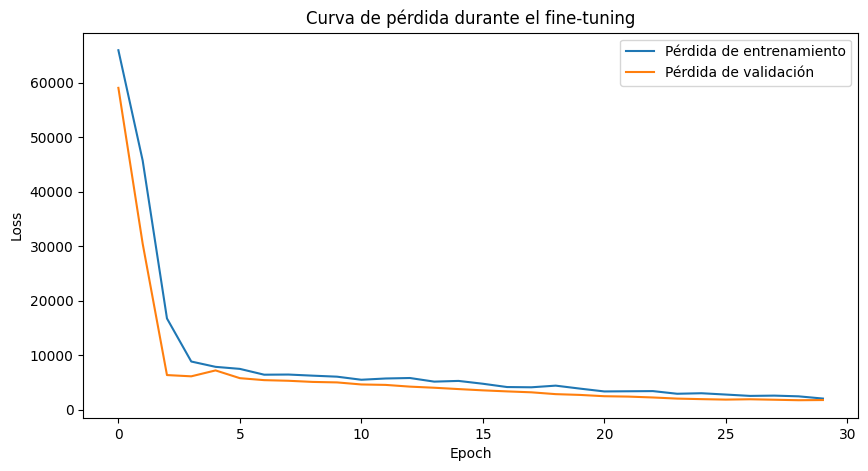

In [ ]:
import matplotlib.pyplot as plt

# Curva de pérdida (MSE o MAE)
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de pérdida durante el fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


RANDOM FOREST BLOQUE

In [ ]:
# Extraer embeddings antes de la última capa
feature_extractor = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("gap").output  # o "head_dense" si quieres incluir la capa densa
)


In [ ]:
import numpy as np

# Función para extraer features y labels de un dataset
def extract_features_labels(dataset, extractor):
    features, labels = [], []
    for batch_x, batch_y in dataset:
        feats = extractor.predict(batch_x, verbose=0)
        features.append(feats)
        labels.append(batch_y.numpy())
    return np.vstack(features), np.concatenate(labels)

X_train, y_train = extract_features_labels(train_ds, feature_extractor)
X_val, y_val = extract_features_labels(val_ds, feature_extractor)

print("Train features:", X_train.shape, "Train labels:", y_train.shape)
print("Val features:", X_val.shape, "Val labels:", y_val.shape)


Train features: (326, 512) Train labels: (326,)
Val features: (82, 512) Val labels: (82,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- Modelo ---
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# --- Predicción ---
y_pred = rf.predict(X_val)

# --- Métricas ---
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)


MSE: 1034.1775911585366
RMSE: 32.15863167422608
MAE: 23.440670731707318
R2: 0.8031132701273054


1) Valores reales vs valores predichos

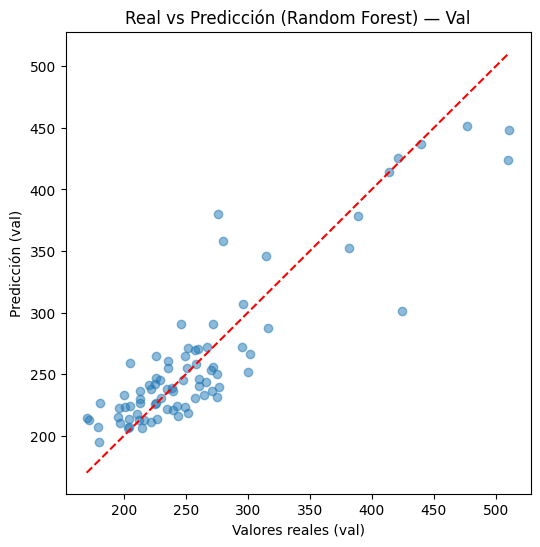

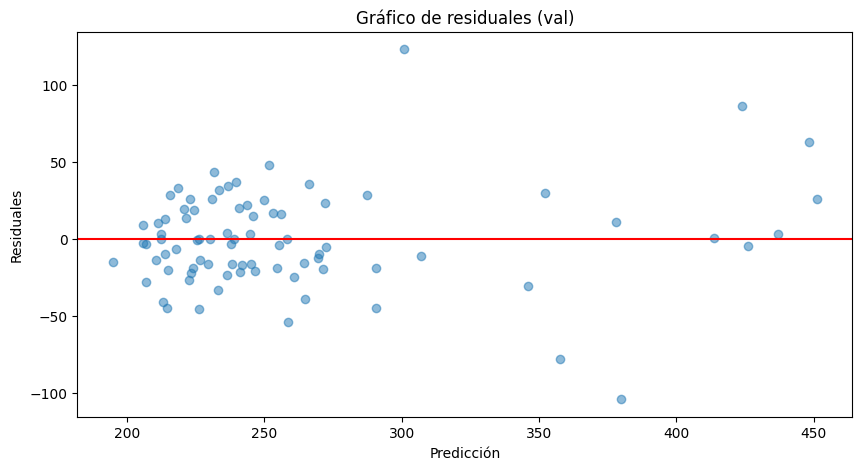

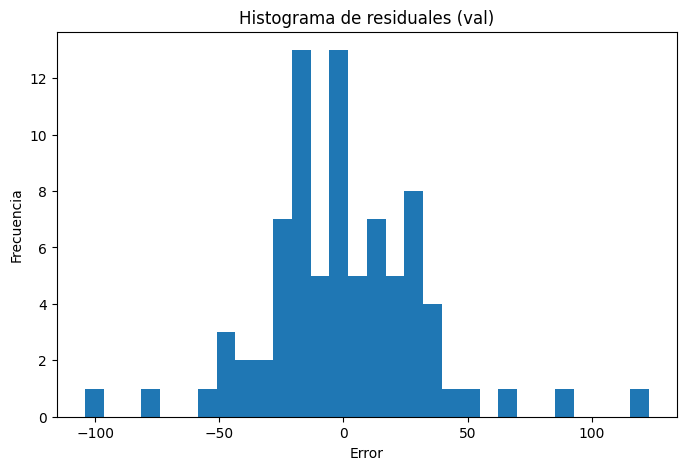

In [ ]:
# Predicción sobre validación
y_pred_val = rf.predict(X_val)

# Real vs Predicción
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Valores reales (val)")
plt.ylabel("Predicción (val)")
plt.title("Real vs Predicción (Random Forest) — Val")
plt.show()

# Residuales
residuals = y_val - y_pred_val
plt.figure(figsize=(10,5))
plt.scatter(y_pred_val, residuals, alpha=0.5)
plt.axhline(0, color='red')
plt.xlabel("Predicción")
plt.ylabel("Residuales")
plt.title("Gráfico de residuales (val)")
plt.show()

# Histograma de errores
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30)
plt.title("Histograma de residuales (val)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.show()


4) Importancia de variables

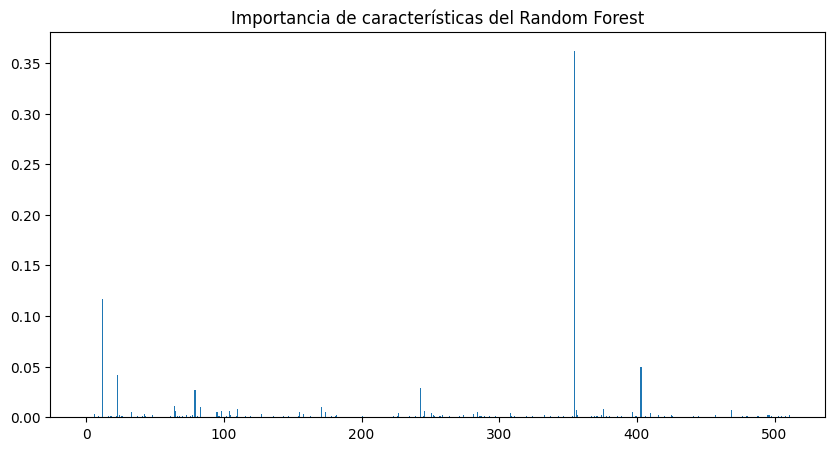

In [ ]:
importances = rf.feature_importances_
plt.figure(figsize=(10,5))
plt.bar(range(len(importances)), importances)
plt.title("Importancia de características del Random Forest")
plt.show()


In [ ]:
# Guardar modelo RF
import joblib
joblib.dump(rf, "/content/drive/My Drive/REGRESION_PESO/rf_model.joblib")

['/content/drive/My Drive/REGRESION_PESO/rf_model.joblib']

# EVALUACION EN EL TEST

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Cargar CSV de test
df_test = pd.read_csv(ruta_test)
filepaths = df_test["filepath"].tolist()
y_true = df_test["weight"].values

# Función para cargar una imagen y dejarla lista para el extractor
def load_and_preprocess_img(path, target_size=(224,224)):
    img = tf.keras.utils.load_img(path, target_size=target_size)
    img = tf.keras.utils.img_to_array(img) / 255.0  # normalizar [0,1]
    return np.expand_dims(img, axis=0)  # (1,H,W,3)


In [ ]:
features_test = []
for path in filepaths:
    img = load_and_preprocess_img(path)
    feat = feature_extractor.predict(img, verbose=0)  # extractor es tu CNN congelada
    features_test.append(feat[0])  # quitar dimensión batch

X_test = np.array(features_test)
print("Features test:", X_test.shape)

Features test: (102, 512)


In [ ]:
y_pred = rf.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print(f"MSE Test:  {mse:.4f}")
print(f"RMSE Test: {rmse:.4f}")
print(f"MAE Test:  {mae:.4f}")
print(f"R² Test:   {r2:.4f}")



MSE Test:  1754.2075
RMSE Test: 41.8833
MAE Test:  29.9175
R² Test:   0.6048


# EVALUACION POR IMAGEN

In [ ]:
from tensorflow.keras.models import Model

# Quitamos la última capa densa ("pred") para que la CNN solo entregue embeddings
feature_extractor_test = Model(inputs=model.input, outputs=model.get_layer("gap").output) # Changed to extract before GlobalAveragePooling2D

In [ ]:
import tensorflow as tf
import numpy as np

def preprocess_image(img_path, target_size=(224,224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # mismo preprocesamiento que en train_ds
    img = np.expand_dims(img, axis=0)  # batch de 1
    return img


In [ ]:
def predict_weight(img_path, feature_extractor_test, rf):
    # 1) Preprocesar imagen
    img = preprocess_image(img_path)

    # 2) Extraer embeddings con la CNN
    features = feature_extractor.predict(img)

    # 3) Pasar features al Random Forest
    pred = rf.predict(features)[0]
    return pred


In [ ]:
img_path = "/content/drive/My Drive/REGRESION_PESO/SELECCION_LIMPIO/BLF2594.jpg"
predicted_weight = predict_weight(img_path, feature_extractor, rf)
print(f"Predicted weight: {predicted_weight:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted weight: 211.12


GRAD-CAM

In [ ]:
def preprocess_image(path, img_size=(224,224)):
    img = tf.keras.preprocessing.image.load_img(path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    return np.expand_dims(img, axis=0)


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="block5_conv3"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array)
        loss = preds[0]    # predicción para retropropagar

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    return heatmap

In [ ]:
def display_gradcam(path, model, last_conv_layer="block5_conv3"):
    img_array = preprocess_image(path)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Imagen original")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed)
    plt.axis("off")

    plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['image']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


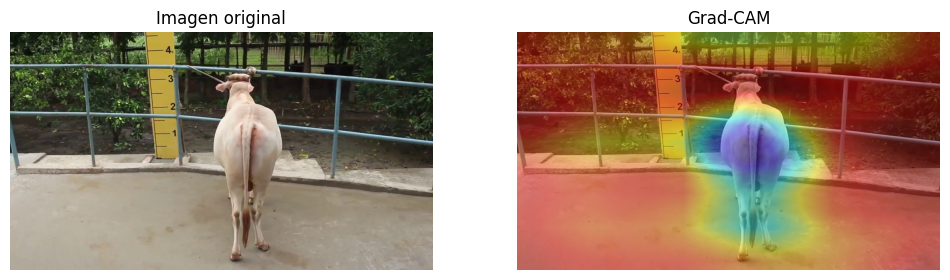

In [ ]:
ruta = "/content/drive/My Drive/REGRESION_PESO/SELECCION_LIMPIO/BLF2594.jpg"
display_gradcam(ruta, model, last_conv_layer="block5_conv3")

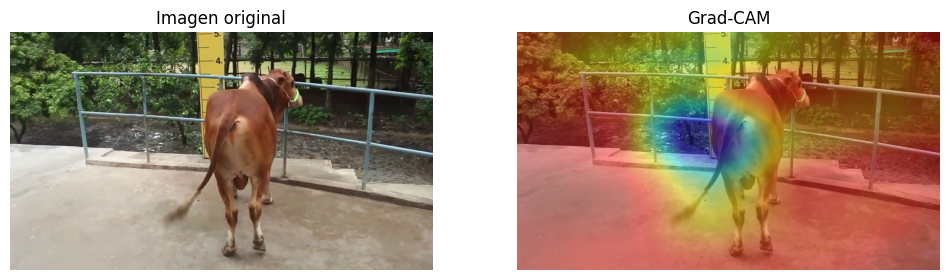

In [ ]:
ruta = "/content/drive/My Drive/REGRESION_PESO/SELECCION_LIMPIO/BLF2673.jpg"
display_gradcam(ruta, model, last_conv_layer="block5_conv3")

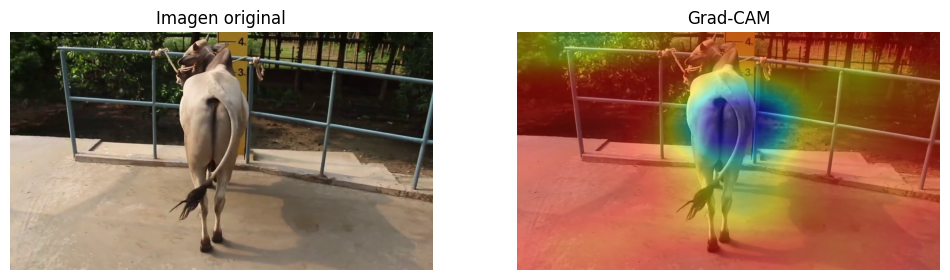

In [ ]:
ruta = "/content/drive/My Drive/REGRESION_PESO/SELECCION_LIMPIO/BLF2031.jpg"
display_gradcam(ruta, model, last_conv_layer="block5_conv3")

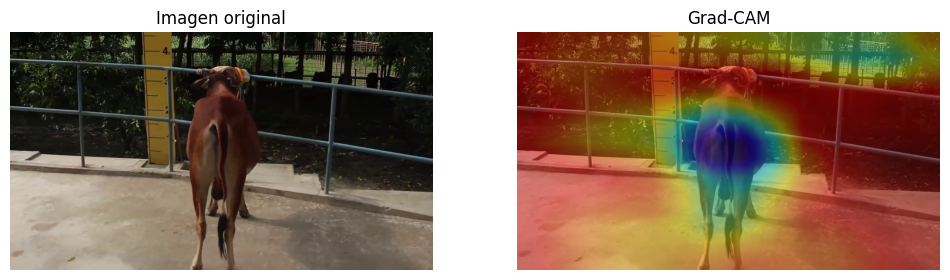

In [ ]:
ruta = "/content/drive/My Drive/REGRESION_PESO/SELECCION_LIMPIO/BLF2620.jpg"
display_gradcam(ruta, model, last_conv_layer="block5_conv3")

In [ ]:
model.summary()

Model: "vgg16_block5_single_stage"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16_preprocess (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dense (Dense)              │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dropout (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 1)              │           25

 Total params: 29,268,293 (111.65 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,422,020 (55.02 MB)

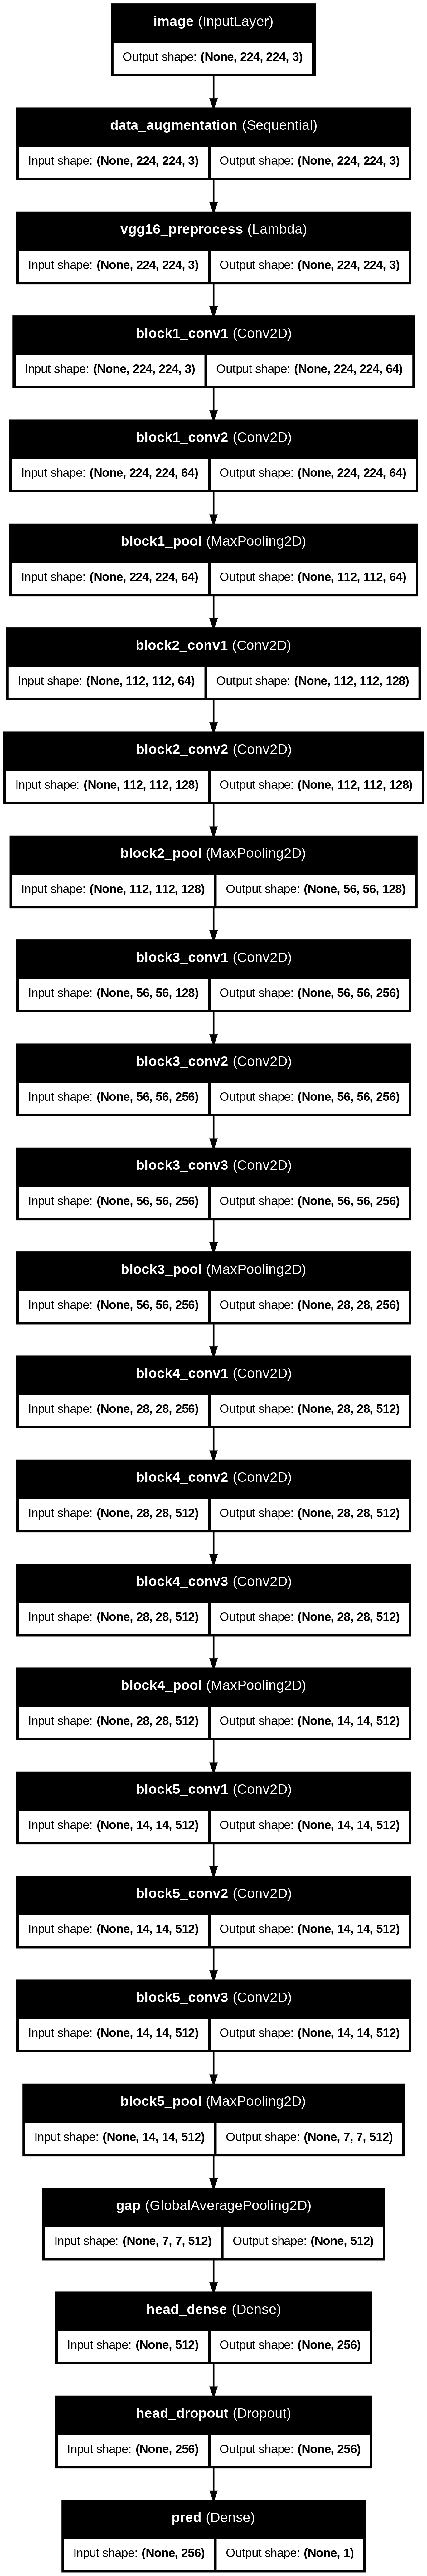

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
)


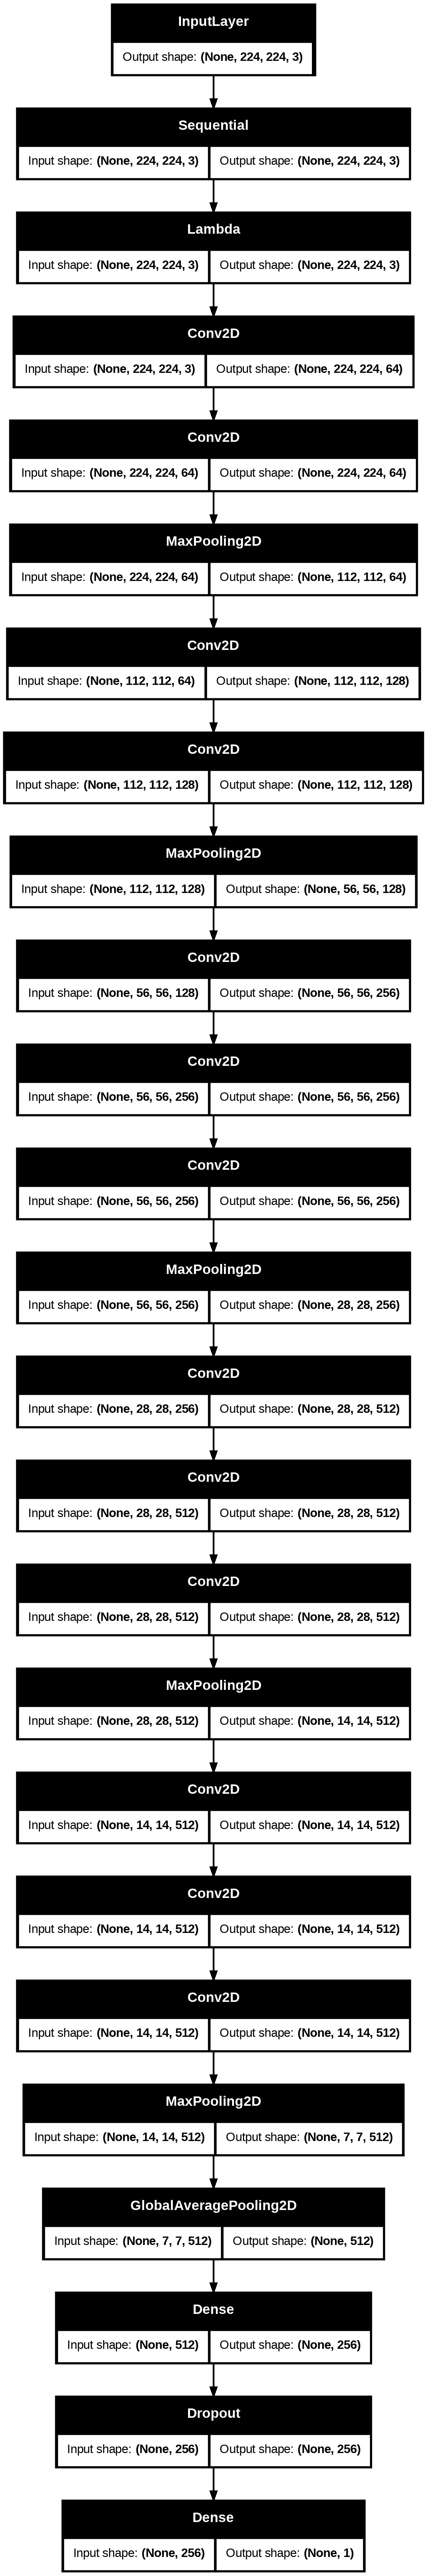

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image("model.png")
